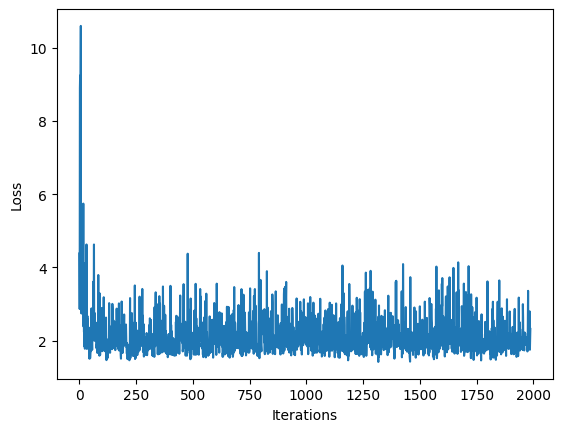

100%|██████████| 2000/2000 [03:31<00:00,  9.46it/s]


tf.Tensor([[42]], shape=(1, 1), dtype=int32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (1, None, 2)              160       
                                                                 
 lstm (LSTM)                 (1, None, 2024)           16410592  
                                                                 
 dense (Dense)               (1, None, 80)             162000    
                                                                 
Total params: 16,572,752
Trainable params: 16,572,752
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 1000/1000 [00:10<00:00, 92.27it/s]


Found 394 songs in text


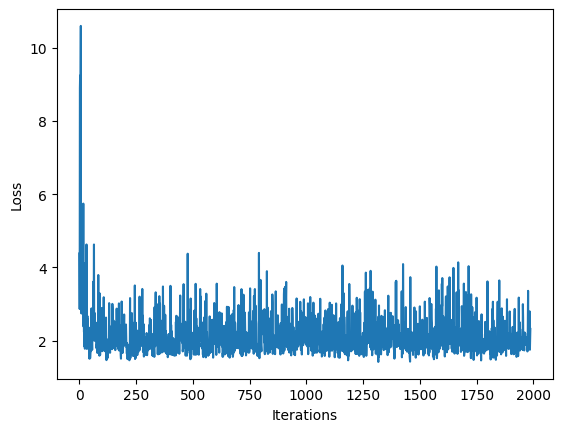

In [1]:
from keras.api._v2.keras.layers import Dropout
%tensorflow_version 2.x
import tensorflow as tf

import numpy as np
import urllib.request
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1

!pip install mitdeeplearning
import mitdeeplearning as mdl


# Load training data
# songs = mdl.lab1.load_training_data()
# Uncomment the line below to load the training data from a different source
songs = urllib.request.urlopen('https://abc.sourceforge.net/NMD/nmd/ashover.txt').read().decode('utf-8')

# Join our list of song strings into a single string containing all songs
songs_joined = "\n\n".join(songs)

# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))

# Define numerical representation of text #
char2idx = {u:i for i, u in enumerate(vocab)}

# Defind character representation of songs string
idx2char = np.array(vocab)

# Vectorize the song string
def vectorize_string(string):
  vectorized_songs = np.zeros(len(string), dtype= np.int32)
  for i in range(len(string)):
    vectorized_songs[i] = char2idx[string[i]]
  return vectorized_songs

# Create training examples
def get_batch(vectorized_songs, seq_len, batch_size):
  n = vectorized_songs.shape[0] - 1
  idx = np.random.choice(n - seq_len, batch_size)
  input_batch = [vectorized_songs[idx[i]: idx[i] + seq_len] for i in range(batch_size)]
  output_batch = [vectorized_songs[idx[i] + 1: idx[i] + 1 + seq_len] for i in range(batch_size)]

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_len])
  y_batch = np.reshape(output_batch, [batch_size, seq_len])
  return x_batch, y_batch

### Define RNN model ###

def LSTM(rnn_units):
  return tf.keras.layers.LSTM(
    rnn_units,
    return_sequences=True,
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
    dropout=0.2,
    )

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]))
  model.add(LSTM(rnn_units))
  model.add(tf.keras.layers.Dense(vocab_size))
  return model

### Hyperparameter and optimizer setting###

vocab_size = len(vocab)
embedding_dim = int(vocab_size ** (1 / 4))
rnn_units = 2024

num_training_iterations = 2000
batch_size = 1
seq_len = 100
learning_rate = 5e-3

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

### Build and Train the RNN model ###

# Compute loss
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits= True)
  return loss

# Build the model
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)

# Optimize the model
optimizer = tf.keras.optimizers.Adam(learning_rate)

def train_step (x , y):
  with tf.GradientTape() as tape:
    y_hat = model(x)
    loss = compute_loss(y, y_hat)

  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables ))

  return loss

history = []
vectorized_songs = vectorize_string(songs_joined)

plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_len, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:
    model.save_weights(checkpoint_prefix)

# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=200):
  input_eval = [char2idx[start_string]]
  input_eval = tf.expand_dims(input_eval, 0)
  print(input_eval)

  # Empty string to store our results
  text_generated = []

  # model.reset_states()
  tqdm._instances.clear()

  model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
  model.build(tf.TensorShape([batch_size, None]))
  model.summary()

  for i in tqdm(range(generation_length)):
      predictions = model(input_eval)
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
      # Pass the prediction along with the previous hidden state as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

### Let's generate a song and listen it###
generated_text = generate_text(model, start_string="R", generation_length=1000)
generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs):
  # Synthesize the waveform from a song
  waveform = mdl.lab1.play_song(song)

  # If its a valid song (correct syntax), lets play it!
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)
